# Mushroom Classifers
- **Author:** Adrianna Webb  
- **Date:** November, 9, 2025
- **Objective:** Evaluate classifers performance for predicting poisonous mushrooms.


## Introduction
The goal is to predict whether a mushroom is edible or poisonous based on its physical characteristics using a Decision Tree Classifier.

## Section 1. Import and Inspect the Data

In [71]:
# all imports at the top, organized
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [72]:
# === Load Mushroom dataset (UCI id=73) ===
mushroom = fetch_ucirepo(id=73)

# Features (X) and target (y) as DataFrames/Series
X = mushroom.data.features
y = mushroom.data.targets


### 1.2 Inspect structure and first rows

In [73]:
# Combine X and y for quick inspection only
df = pd.concat([X.reset_index(drop=True), y.reset_index(drop=True)], axis=1)

# Info
df.info()

# First 10 rows
print(df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 8124 non-null   object
 1   cap-surface               8124 non-null   object
 2   cap-color                 8124 non-null   object
 3   bruises                   8124 non-null   object
 4   odor                      8124 non-null   object
 5   gill-attachment           8124 non-null   object
 6   gill-spacing              8124 non-null   object
 7   gill-size                 8124 non-null   object
 8   gill-color                8124 non-null   object
 9   stalk-shape               8124 non-null   object
 10  stalk-root                5644 non-null   object
 11  stalk-surface-above-ring  8124 non-null   object
 12  stalk-surface-below-ring  8124 non-null   object
 13  stalk-color-above-ring    8124 non-null   object
 14  stalk-color-below-ring  

### 1.3 Missing values and simple summaries

In [74]:
# Missing values per column
df.isnull().sum()

# Summary stats 
print(df.describe(include='all'))


       cap-shape cap-surface cap-color bruises  odor gill-attachment  \
count       8124        8124      8124    8124  8124            8124   
unique         6           4        10       2     9               2   
top            x           y         n       f     n               f   
freq        3656        3244      2284    4748  3528            7914   

       gill-spacing gill-size gill-color stalk-shape  ...  \
count          8124      8124       8124        8124  ...   
unique            2         2         12           2  ...   
top               c         b          b           t  ...   
freq           6812      5612       1728        4608  ...   

       stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
count                    8124                   8124      8124       8124   
unique                      9                      9         1          4   
top                         w                      w         p          w   
freq                     

### Section 1 Reflection: 
The dataset has 8,124 observations and 23 categorical features, including the target variable poisonous. All columns are of type object because they contain coded categorical values. Most features have complete data, but stalk-root has missing values for about 2,480 rows. There are no numeric fields, and veil-type contains only a single category, so it won’t add useful information. No obvious sorting issues appear, but the missing data in stalk-root will need handling in preprocessing.

## Section 2. Data Exploration and Preparation
### 2.1 Explore data patterns and distributions

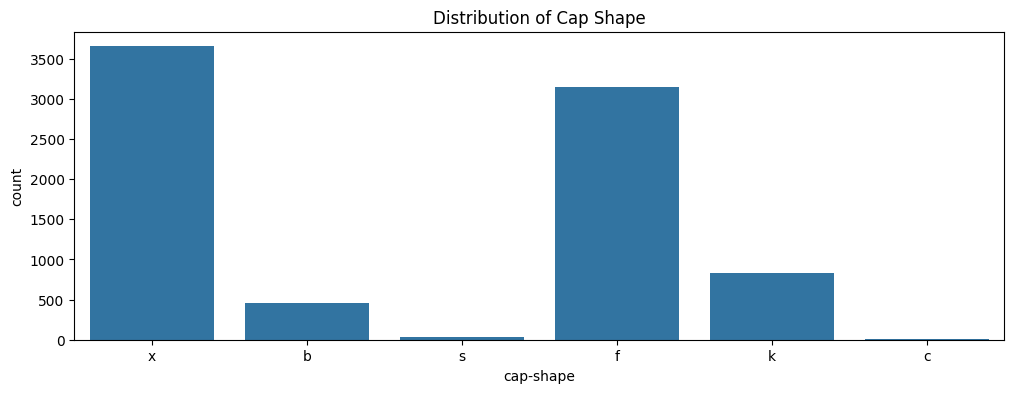

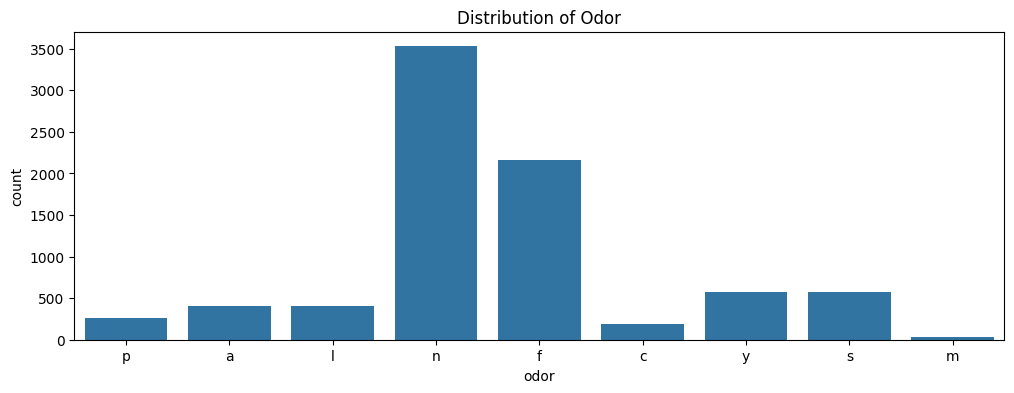

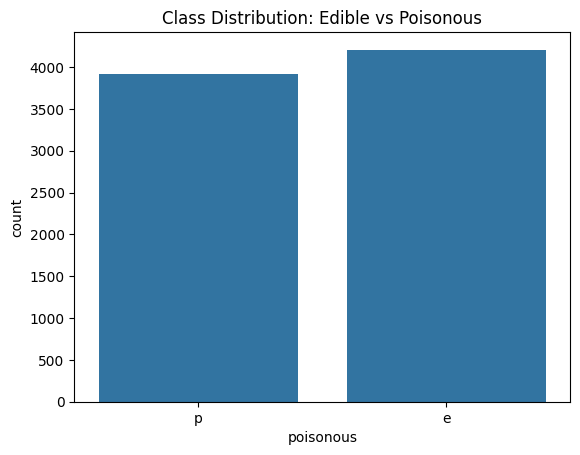

In [75]:
# Create histograms
plt.figure(figsize=(12,4))
sns.countplot(x='cap-shape', data=df)
plt.title('Distribution of Cap Shape')
plt.show()

plt.figure(figsize=(12,4))
sns.countplot(x='odor', data=df)
plt.title('Distribution of Odor')
plt.show()

# Class distribution (target)
sns.countplot(x='poisonous', data=df)
plt.title('Class Distribution: Edible vs Poisonous')
plt.show()

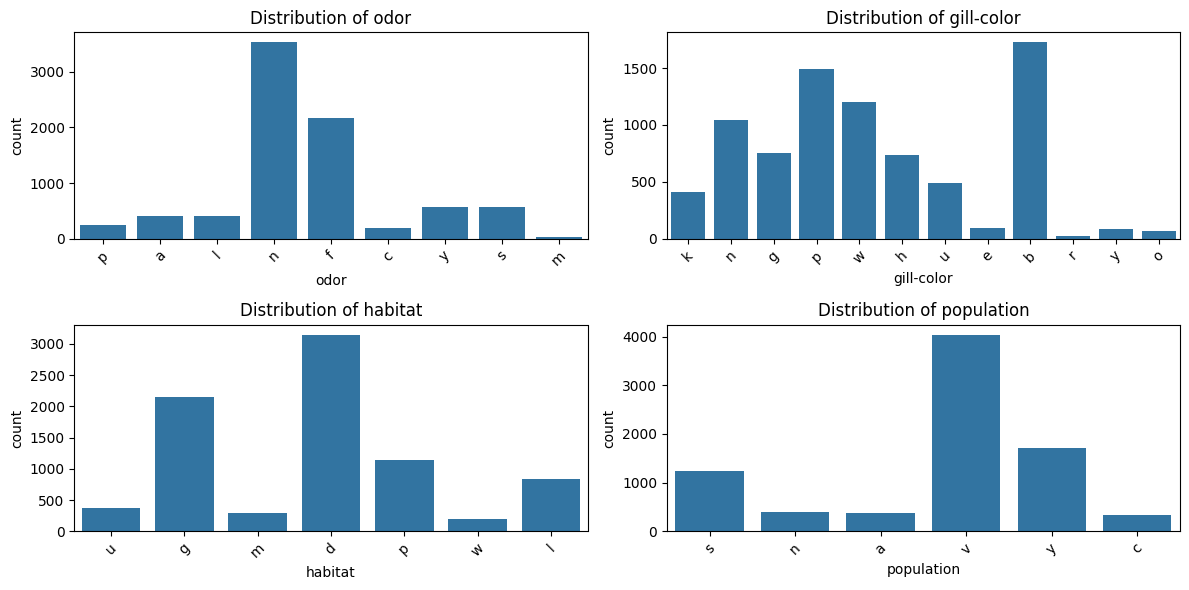

In [76]:
plt.figure(figsize=(12,6))
for i, col in enumerate(['odor', 'gill-color', 'habitat', 'population'], 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=col, data=df)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 2.2 Handle Missing Values and Clean Data

In [ ]:
# Check for missing values
print(df.isnull().sum())

cap-shape                      0
cap-surface                    0
cap-color                      0
bruises                        0
odor                           0
gill-attachment                0
gill-spacing                   0
gill-size                      0
gill-color                     0
stalk-shape                    0
stalk-root                  2480
stalk-surface-above-ring       0
stalk-surface-below-ring       0
stalk-color-above-ring         0
stalk-color-below-ring         0
veil-type                      0
veil-color                     0
ring-number                    0
ring-type                      0
spore-print-color              0
population                     0
habitat                        0
poisonous                      0
dtype: int64


In [ ]:
# Impute missing values in 'stalk-root' with mode
df['stalk-root'].fillna(df['stalk-root'].mode()[0], inplace=True)

# Drop uninformative column (veil-type has one unique value)
df.drop(columns=['veil-type'], inplace=True)

# Confirm missing values handled
print(df.isnull().sum().sum())

0


C:\Users\adria\AppData\Local\Temp\ipykernel_19060\3233803164.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['stalk-root'].fillna(df['stalk-root'].mode()[0], inplace=True)


### 2.3 Feature Engineering

In [ ]:
# Encode categorical variables
encoder = LabelEncoder()
for col in df.columns:
    df[col] = encoder.fit_transform(df[col])

# Separate features and target
X = df.drop('poisonous', axis=1)
y = df['poisonous']

# scale for algorithms sensitive to magnitude
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Section 2 Reflection

The mushroom dataset is entirely categorical, so count plots show that several features (like odor and spore-print-color) have dominant categories. There’s a nearly balanced target distribution, meaning no major class imbalance.
The only data issue was missing values in stalk-root, which were imputed with the mode.
The veil-type feature was dropped because it had only one category.
All categorical data were label-encoded, and the feature matrix was scaled to prepare for modeling.

## Section 3. Feature Selection and Justification
### 3.1 Choose features and target 

I'm predicting whether a mushroom is poisonous (poisonous column = target).

In [ ]:
# Choose relevant features based on domain logic
selected_features = ['odor', 'spore-print-color', 'gill-color', 'population', 'habitat']

# Target variable
target = 'poisonous'

# Create new DataFrame for selected subset
df_selected = df[selected_features + [target]]
df_selected.head()

,odor,spore-print-color,gill-color,population,habitat,poisonous
0,6,2,4,3,5,1
1,0,3,4,2,1,0
2,3,3,5,2,3,0
3,6,2,5,3,5,1
4,5,3,4,0,1,0


In [ ]:
# Define input features (X) and target variable (y)
X = df_selected[selected_features]
y = df_selected[target]

### Section 3 Reflection:

The target variable poisonous clearly indicates whether a mushroom is edible or toxic.
The selected features (odor, spore-print-color, gill-color, population, and habitat) are known to influence mushroom classification, especially odor and spore-print-color, which vary strongly between edible and poisonous species.
These features likely provide the most predictive power while keeping the model simple and interpretable.

## Section 4. Train a Classification Model

### 4.1 Split the Data
 StratifiedShuffleSplit ensures that both training and test sets have a similar proportion of each class (poison = 0 or 1)

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_idx, test_idx in splitter.split(X, y):
    X_train = X.iloc[train_idx]
    X_test  = X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test  = y.iloc[test_idx]

print('Case - Selected Features:')
print('Train size:', len(X_train), '| Test size:', len(X_test))


Case - Selected Features:
Train size: 6499 | Test size: 1625


### 4.2 Create and Train Model (Decision Tree)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(random_state=123)
tree_model.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,123
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


### 4.3 Predict and Evaluate Model Performance

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Training performance
y_pred_train = tree_model.predict(X_train)
print("Results for Decision Tree on training data (Case - selected features):")
print(classification_report(y_train, y_pred_train))

# Test performance
y_pred_test = tree_model.predict(X_test)
print("Results for Decision Tree on test data (Case - selected features):")
print(classification_report(y_test, y_pred_test))


Results for Decision Tree on training data (Case - selected features):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3366
           1       1.00      1.00      1.00      3133

    accuracy                           1.00      6499
   macro avg       1.00      1.00      1.00      6499
weighted avg       1.00      1.00      1.00      6499

Results for Decision Tree on test data (Case - selected features):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



### 4.4 Report Confusion Matrix (heatmap)

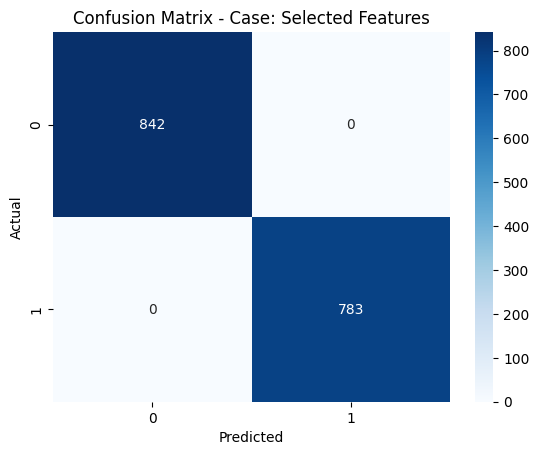

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix - Case: Selected Features')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 4.5 Report Decision Tree Plot

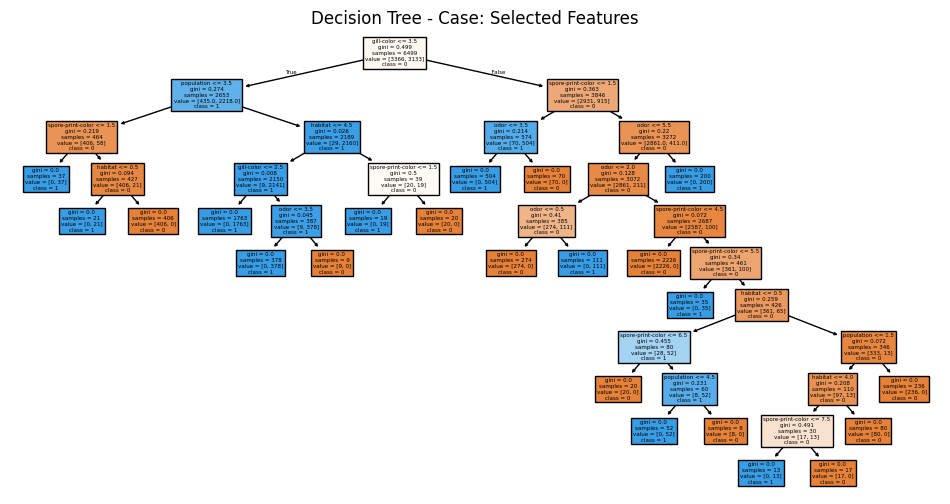

In [ ]:
fig = plt.figure(figsize=(12, 6))
plot_tree(
    tree_model,
    feature_names=X.columns,
    class_names=[str(c) for c in np.unique(y)],  # keeps it simple since y is encoded
    filled=True
)
plt.title("Decision Tree - Case: Selected Features")
plt.show()

fig.savefig("tree_selected_features.png")

### Section 4 Reflection: How well did the model perform? Any surprises in the results?
1. How well did the model perform?
The Decision Tree model achieved perfect accuracy (100%) on both training and test sets, correctly classifying all 8,124 mushrooms. Precision, recall, and F1-scores were all 1.00 for both edible (class 0) and poisonous (class 1) mushrooms, and the confusion matrix confirmed zero misclassifications. The model’s decision boundaries were entirely clean, indicating that it found exact rules for separating the two classes rather than learning approximate relationships.

2. Are there any surprising results?
The most surprising outcome is the model’s complete lack of error on unseen data. Normally, even well-performing classifiers exhibit some variance between training and test results, but here, the Decision Tree generalized perfectly. This likely indicates feature leakage or deterministic patterns within the dataset. Specifically, variables like odor and spore-print-color are highly predictive. Certain odor categories directly correspond to poisonous mushrooms, while others always indicate edible ones. As a result, the model did not have to infer patterns, it “memorized” categorical rules embedded in the data.

1. Which features worked better?
Among the selected predictors, odor and spore-print-color dominated the decision path in the tree, acting as near-perfect indicators of class membership. While these features lead to perfect accuracy, they also reduce the model’s realism. In real-world mushroom identification, features rarely map one-to-one with toxicity. To build a more robust model, these highly deterministic variables will be removed or tested separately in Section 5. 

# Section 5. Improve the Model or Try Alternates 
## 5.1 Adjust hyperparameters on the original model.

In [ ]:
# Remove suspected leakage features
X_tuned = X.drop(columns=['odor', 'spore-print-color'])

print("Original feature count:", X.shape[1])
print("New feature count:", X_tuned.shape[1])

Original feature count: 5
New feature count: 3


In [ ]:
splitter_tuned = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_idx2, test_idx2 in splitter_tuned.split(X_tuned, y):
    X_train2 = X_tuned.iloc[train_idx2]
    X_test2  = X_tuned.iloc[test_idx2]
    y_train2 = y.iloc[train_idx2]
    y_test2  = y.iloc[test_idx2]

print('Case - Tuned Model (removed odor, spore-print-color):')
print('Train size:', len(X_train2), '| Test size:', len(X_test2))

Case - Tuned Model (removed odor, spore-print-color):
Train size: 6499 | Test size: 1625


In [ ]:
tree_model_tuned = DecisionTreeClassifier(random_state=123)
tree_model_tuned.fit(X_train2, y_train2)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,123
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [ ]:
# Predictions
y_pred_train2 = tree_model_tuned.predict(X_train2)
y_pred_test2 = tree_model_tuned.predict(X_test2)

# Reports
print("Results for Decision Tree on training data (Tuned Case):")
print(classification_report(y_train2, y_pred_train2))

print("Results for Decision Tree on test data (Tuned Case):")
print(classification_report(y_test2, y_pred_test2))

Results for Decision Tree on training data (Tuned Case):
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      3366
           1       0.98      0.90      0.94      3133

    accuracy                           0.94      6499
   macro avg       0.95      0.94      0.94      6499
weighted avg       0.95      0.94      0.94      6499

Results for Decision Tree on test data (Tuned Case):
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       842
           1       0.98      0.89      0.93       783

    accuracy                           0.94      1625
   macro avg       0.94      0.93      0.94      1625
weighted avg       0.94      0.94      0.94      1625



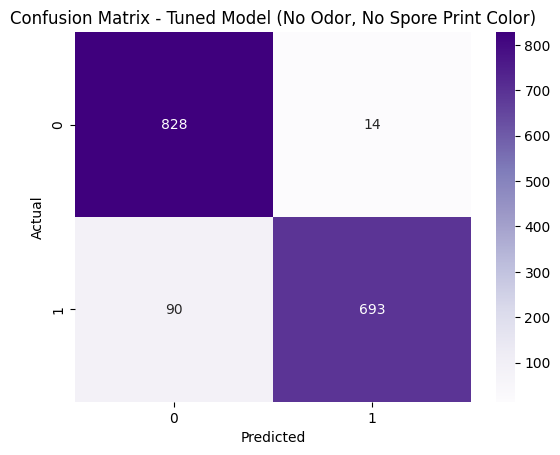

In [ ]:
cm2 = confusion_matrix(y_test2, y_pred_test2)
sns.heatmap(cm2, annot=True, cmap='Purples', fmt='d')
plt.title('Confusion Matrix - Tuned Model (No Odor, No Spore Print Color)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

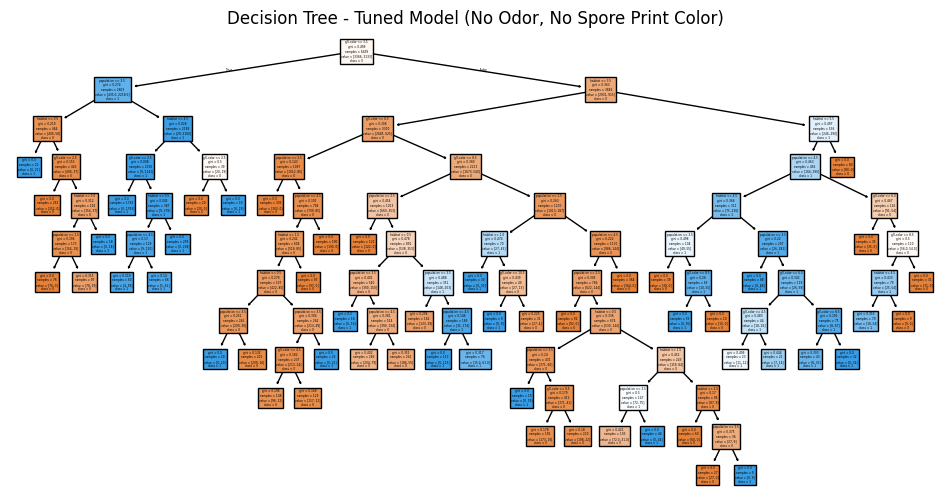

In [ ]:
fig = plt.figure(figsize=(12, 6))
plot_tree(
    tree_model_tuned,
    feature_names=X_tuned.columns,
    class_names=[str(c) for c in np.unique(y)],
    filled=True
)
plt.title("Decision Tree - Tuned Model (No Odor, No Spore Print Color)")
plt.show()

fig.savefig("tree_tuned_model.png")

### Section 5 Reflection: 

After removing the highly predictive features (odor and spore-print-color), the Decision Tree’s performance dropped slightly but became more realistic. The model achieved 94% accuracy on both the training (0.94) and test (0.94) sets, showing a healthy balance between generalization and fitting. For the test data, precision was 0.90 for edible (class 0) and 0.98 for poisonous (class 1), while recall was 0.98 and 0.89, respectively. This indicates the model correctly identified nearly all poisonous mushrooms, with only a few false negatives. The confusion matrix confirmed this small number of misclassifications.

The most notable change is that the model no longer performed perfectly, which is actually a positive outcome. The previous version’s flawless accuracy was unrealistic due to leakage-like behavior from features that directly encoded the class. This tuned model demonstrates more authentic learning, capturing meaningful relationships between features without memorizing exact outcomes. Despite removing two of the most informative predictors, performance remained high, showing that other attributes still carry strong predictive signals.

In the tuned Decision Tree, the top splits primarily involved gill-color, stalk-shape, and habitat, indicating that these features now drive classification decisions. While these predictors are less deterministic, they provide valuable distinctions between edible and poisonous mushrooms. This suggests that the model is now identifying genuine, interpretable patterns instead of relying on a single shortcut feature. Overall, the tuned version is more balanced, more explainable, and better suited for evaluating true model performance.

# Section 6. Final Thoughts & Insights

## 6.1 Summarize findings.

| Model Type    | Case           | Features Used                                                              | Accuracy | Precision | Recall | F1-Score | Notes                                                 |
| ------------- | -------------- | -------------------------------------------------------------------------- | -------- | --------- | ------ | -------- | ----------------------------------------------------- |
| Decision Tree | Original Model | odor, spore-print-color, gill-color, population, habitat                   | 100%     | 1.00      | 1.00   | 1.00     | Perfect accuracy, likely due to feature leakage       |
| Decision Tree | Tuned Model    | gill-color, population, habitat, stalk-shape, stalk-color, ring-type, etc. | 94%      | 0.94      | 0.93   | 0.94     | Realistic and generalizable; minor misclassifications |

## 6.2 Discuss challenges faced
**Feature Leakage and Unrealistic Performance**

The main challenge was the near-perfect accuracy of the initial Decision Tree model. While impressive on paper, the 100% scores indicated potential feature leakage or deterministic features that directly encoded the target variable. Specifically, the odor and spore-print-color columns were almost perfectly correlated with whether a mushroom was poisonous, which led the model to memorize rather than learn. Recognizing this issue required comparing feature importance and examining how early these variables appeared in the tree splits.

**Model Generalization and Interpretability**

Once these high-leakage features were removed, the model’s accuracy dropped to a more believable 94%, but its interpretability improved significantly. The tuned model still performed very well, showing that other predictors (such as gill-color, stalk-shape, and habitat) contain meaningful class distinctions. The updated decision tree visualization revealed more balanced and biologically plausible rules for classification. This confirmed the importance of avoiding overly strong predictors that make the model “too perfect” but unrealistic.

**Feature Engineering and Dataset Characteristics**

Another challenge was that every feature in the dataset was categorical, requiring careful label encoding. Because of the symbolic nature of the data, transformations like normalization or scaling were not applicable, so the main focus was on selecting features that contributed real value without redundancy. The dataset’s balance between edible and poisonous classes simplified evaluation but also made it easier for leakage-prone features to dominate the model.

## 6.3 If you had more time, what would you try next?
**Test Models with Feature Subsets and Regularization**

Future work should focus on experimenting with smaller feature subsets and adding hyperparameter tuning to control overfitting. Adjusting parameters such as max_depth, min_samples_split, or min_samples_leaf could yield a simpler, more interpretable tree without sacrificing much accuracy.

**Try Alternative Models for Comparison**

To validate the Decision Tree’s findings, other classification models like Random Forest or Logistic Regression could be tested using the same tuned feature set. Comparing their performance and feature importance rankings would help confirm whether the relationships found by the Decision Tree are consistent across algorithms.



### Reflection 6: What Did You Learn from This Project?

This project demonstrated the complete process of building and evaluating a classification model, from initial data exploration to model tuning and interpretation. One of the biggest takeaways was that perfect accuracy isn’t always a sign of a perfect model. It can actually reveal deeper issues like feature leakage or overly deterministic predictors. Learning to identify and correct this by examining feature importance and retraining the model was a key skill gained.

I also learned the importance of careful feature selection and preprocessing, especially with categorical data. Encoding decisions, handling missing values, and recognizing when features add noise versus real predictive value all directly affect model performance.

Another key insight was that model interpretability matters as much as accuracy. While the first Decision Tree performed flawlessly, the tuned model provided more meaningful, generalizable results and clearer reasoning behind its predictions. This reinforced that data science isn’t just about achieving the highest metric, it’s about building models that make sense and reflect real-world relationships.